This file contains auxiliary analyses on MIMIC-CXR models trained to predict No Finding.

Specifically, it contains the following sections:
- Section 1: Replicates **Table S4** and **Table S5** by computing disease prevalences on the FP No Finding cohort.
- Section 2: We demonstrate a method to equalize FPR and FNR between Whites and Blacks by using per-group thresholding, as mentioned in the discussion of the paper.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd 
import pickle
import json
import torch
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
from netcal.metrics import ECE
from scipy.stats import logistic
import scipy.stats as st
import warnings
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import wilcoxon, ranksums
from tqdm import tqdm

from sklearn.metrics import recall_score, matthews_corrcoef, roc_auc_score, f1_score, roc_curve, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

def capscase(string):
    return string[0].upper() + string[1:].lower()

def compute_opt_thres(target, pred):
    opt_thres = 0
    opt_f1 = 0
    for i in np.arange(0.05, 0.9, 0.01):
        f1 = f1_score(target, pred >= i)
        if f1 >= opt_f1:
            opt_thres = i
            opt_f1 = f1
    return opt_thres

def tnr(target, pred):
    CM = confusion_matrix(target, pred, labels=[0, 1])
    
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    return TN/(TN + FP) if (TN + FP) > 0 else 0

def stats(targets_r, preds_rounded_r, preds_r):
    res = {}
    res['fnr'] = 1-recall_score(targets_r, preds_rounded_r)
    res['fpr'] = 1-tnr(targets_r, preds_rounded_r)
    res['roc'] = roc_auc_score(targets_r, preds_r)
    res['ece'] = ECE().measure(y= targets_r.values, X =preds_r.values)
    return res

root_dir = Path('/scratch/ssd001/home/haoran/projects/CXR_Bias/MIMIC-CSV/')

tasks = ['No Finding']

meta = pd.read_csv(root_dir/'True_withMeta.csv')

## Section 1: Disease Prevalences in Different Cohorts

In [2]:
folders = ['results19', 'results31', 'results38', 'results47', 'results77']
thresholds = []
dfs = []
for f in folders:
    temp = pd.read_csv(root_dir/f/'preds.csv')
    dfs.append(pd.merge(meta, temp, on = 'path', how = 'inner'))
    dfs[-1].loc[dfs[-1].race == '0', 'race'] = 'UNKNOWN'
    dfs[-1].loc[dfs[-1].insurance == '0', 'insurance'] = 'UNKNOWN'
    thresholds.append(pd.read_csv(root_dir/f/'Threshold.csv').set_index('label').loc['No Finding']['bestthr'])

In [3]:
selectors = {
    "White Male": 'race == "WHITE" and  gender == "M"',
    "White Female": 'race == "WHITE" and  gender == "F"',
    "Black Male": 'race == "BLACK/AFRICAN AMERICAN" and  gender == "M"',
    "Black Female": 'race == "BLACK/AFRICAN AMERICAN" and  gender == "F"'   
}

In [4]:
tasks = ['Airspace Opacity', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Pleural Effusion', 'Pleural Other',
       'Pneumonia', 'Pneumothorax']

mapping = {i:i for i in tasks}
mapping['Enlarged Cardiomediastinum'] = 'Enlarged Cardio.'

data_for_table = {}
data_for_table2 = {}
counts_all_raw = {}
for c, select in enumerate(selectors):    
    temp = []
    temp_count = []
    count_all = []
    for d, df in enumerate(dfs):
        df = df.query(selectors[select])
        
        if d == 0:
            points = df.loc[df['No Finding'] == 0.0, tasks].describe().loc['mean']
            # points = df[tasks].describe().loc['mean']
            points_count = points*((df['No Finding'] == 0.0).sum())
            points[points_count <= 15] = -100 
        
        fprs_i = df[(df['prob_No Finding'] >= thresholds[d]) & (df['No Finding'] == 0.0)]
        mask_i = fprs_i[tasks].sum() <= 15
        dist_i = fprs_i[tasks].describe().loc['mean'].rename(d)
        dist_i[mask_i] = -1
        count_i = fprs_i[tasks].describe().loc['mean'].rename(d)*len(fprs_i)
        temp.append(dist_i)
        temp_count.append(count_i)
        count_all.append([(df['No Finding'] == 0.0).sum(), len(fprs_i)])
        
    df_dist_1 = pd.DataFrame(temp).T.reset_index().rename(columns = {'index': 'Diagnosis'})
    all_mask = (df_dist_1.set_index('Diagnosis')[list(range(5))] == -1).any(axis = 1)
    masked_tasks = all_mask[all_mask].index
    df_dist = pd.melt(df_dist_1, id_vars = ['Diagnosis'], value_vars = [0, 1, 2, 3, 4])
    df_dist.loc[df_dist.Diagnosis.isin(masked_tasks), 'value'] = -1
    
    counts_all_raw[select] = count_all
    
    df_dist_2 = pd.DataFrame(temp_count).T.reset_index().rename(columns = {'index': 'Diagnosis'})
            
    data_for_table[select] = [df_dist_1, points]
    data_for_table2[select] = [df_dist_2, points_count]

In [5]:
def format_series(df, fmt):
    means = df.mean(axis = 1)
    sems = df.sem(axis = 1)
    raw = {}    
    
    for task in tasks:
        intv = st.t.interval(0.95, 4, loc=means[task], scale=sems[task])
        if np.all(pd.isnull(intv)):
            intv = [0.0, 0.0]
        # raw[task] = '{:>5} [{:>5}, {:>5}]'.format(fmt(means[task]), fmt(intv[0]), fmt(intv[1]))
        raw[task] = '%s [%s, %s]'%(fmt(means[task]), fmt(intv[0]), fmt(intv[1]))
    return pd.Series(raw)    

In [6]:
fmt = lambda x: "{:.1%}".format(x)

for select in data_for_table:
    data_for_table[select] = {
        'FP No Finding': format_series(data_for_table[select][0].set_index('Diagnosis'), fmt),
        'Not Healthy': data_for_table[select][1].apply(fmt)
    }

dict_of_df = {k: pd.DataFrame(v) for k,v in data_for_table.items()}
df = pd.concat(dict_of_df, axis=1)

df.style.set_properties(**{'white-space': 'pre'})

/h/haoran/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/h/haoran/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [8]:
fmt = lambda x: "{0:.0f}".format(x)

for select in counts_all_raw:
    mean = np.mean(np.array(counts_all_raw[select])[:, 1])
    intv = st.t.interval(0.95, 4, loc=mean, scale=st.sem(np.array(counts_all_raw[select])[:, 1]))
    if np.all(pd.isnull(intv)):
        intv = [0.0, 0.0]
    counts_all_raw[select] = {
        'FP No Finding':  '{:>5} [{:>5}, {:>5}]'.format(fmt(mean), fmt(intv[0]), fmt(intv[1])), 
        'Not Healthy': counts_all_raw[select][0][0]
    }
    
df = pd.DataFrame(counts_all_raw)
df.style.set_properties(**{'white-space': 'pre'})

,White Male,White Female,Black Male,Black Female
FP No Finding,"1153 [ 1090, 1216]","823 [ 770, 876]","295 [ 284, 306]","512 [ 492, 533]"
Not Healthy,6688,4930,1152,1772


##  Section 2: Equal Odds with Per-Group Thresholding

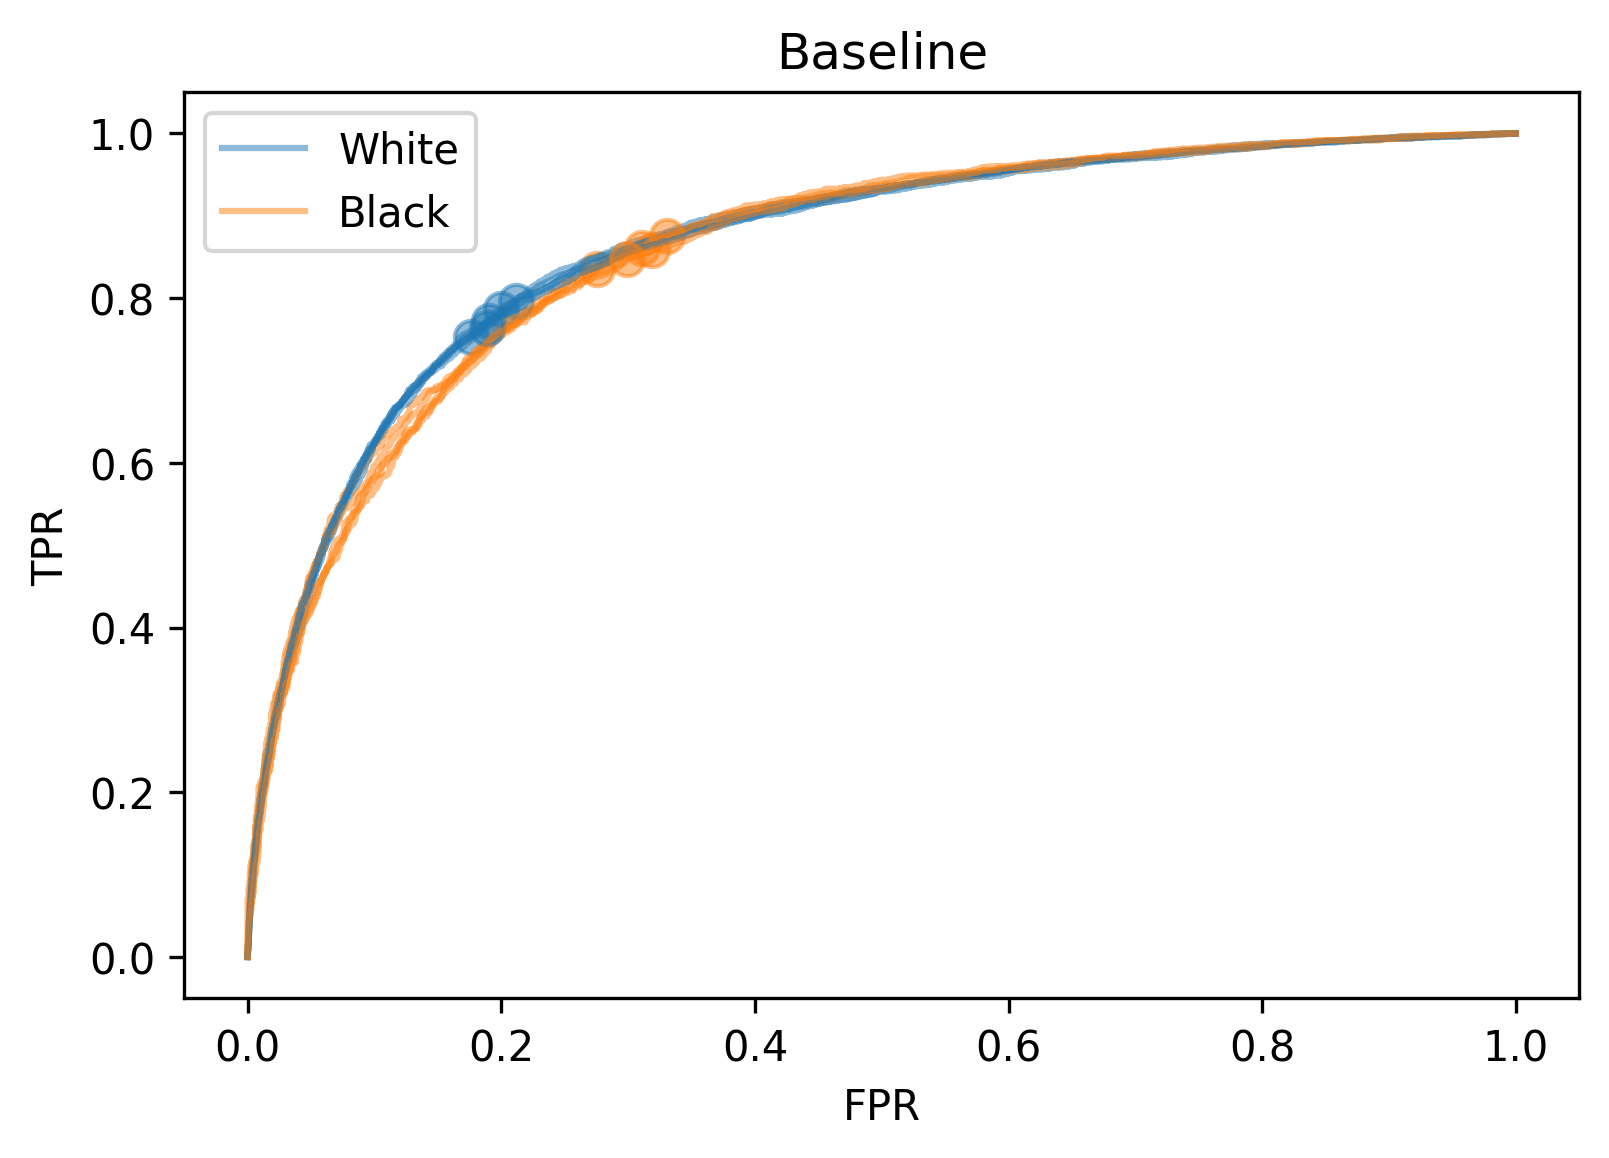

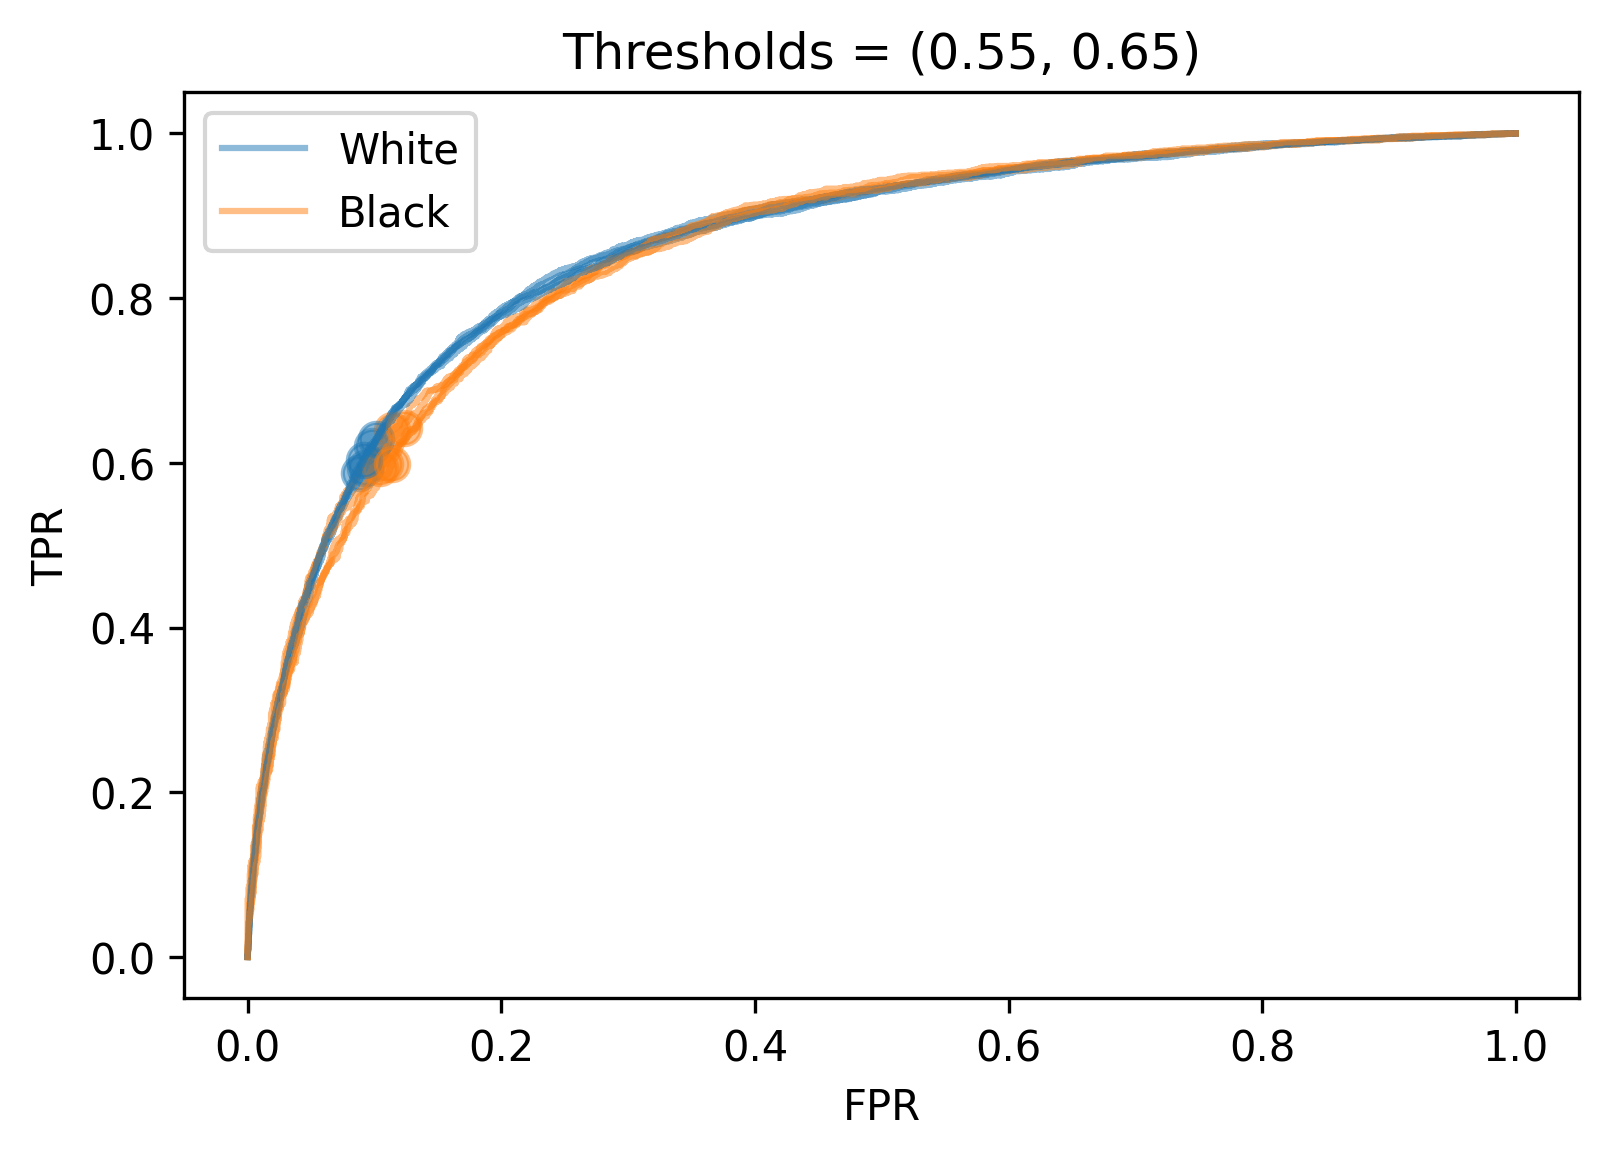

In [17]:
def plot_one_curve(targets, preds, mask, label, compr_thres, color, **kwargs):
    fpr, tpr, thresholds = roc_curve(targets[mask], preds[mask])
    plt.plot(fpr, tpr, label = label, c = color, **kwargs)
    ind_pt = np.argmin(np.abs(thresholds - compr_thres))
    plt.plot(fpr[ind_pt], tpr[ind_pt], 'o', markersize = 8, c = color, **kwargs)
    

thress = [
    (None, None), # default (same threshold across groups)
    (0.55, 0.65) # different threshold for Whites and Blacks
]

for t1, t2 in thress:
    plt.figure(dpi = 300)  
    for c, df in enumerate(dfs):    
        t1 = thresholds[c] if t1 is None else t1
        t2 = thresholds[c] if t2 is None else t2
        
        targets, preds = df['No Finding'], df['prob_No Finding']
        w_mask = df.race == 'WHITE'
        b_mask = df.race == 'BLACK/AFRICAN AMERICAN'

        plot_one_curve(targets, preds, w_mask, 'White' if c == len(dfs) -1 else '', t1, color = 'C0', alpha = 0.5)
        plot_one_curve(targets, preds, b_mask, 'Black' if c == len(dfs) -1 else '', t2, color = 'C1', alpha = 0.5)

    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend()
    if t1 == t2:
        plt.title("Baseline")
    else:
        plt.title('Thresholds = (%s, %s)' % (t1, t2))
    plt.show()